In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils, pickle, bz2
reload(mlutils)
%matplotlib inline

/opt/miniconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### in this lab we will use the model trained in the notes to classify a different and smaller dataset

## Load the dataset

In [2]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar_2.h5

--2019-03-21 06:33:48--  https://s3.amazonaws.com/rlx/mini_cifar_2.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.108.69
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.108.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9943835 (9.5M) [application/x-www-form-urlencoded]
Saving to: ‘mini_cifar_2.h5’

mini_cifar_2.h5     100%[===================>]   9.48M   117KB/s    in 45s     

2019-03-21 06:34:35 (214 KB/s) - ‘mini_cifar_2.h5’ saved [9943835/9943835]



(0.0, 1.0)

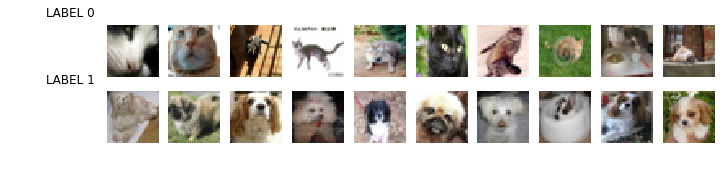

In [5]:
import h5py
with h5py.File('mini_cifar_2.h5','r') as h5f:
    x_cifar = h5f["x"][:][:1000]
    y_cifar = h5f["y"][:][:1000]
    
x_cifar = x_cifar[y_cifar!=2]    
y_cifar = y_cifar[y_cifar!=2]    
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)
np.min(x_cifar), np.max(x_cifar)

## we use a small set of images for train

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.2)
print x_train.shape, y_train.shape, x_test.shape, y_test.shape
print "\ndistribution of train classes"
print pd.Series(y_train).value_counts()
print "\ndistribution of test classes"
print pd.Series(y_test).value_counts()



(800, 32, 32, 3) (800,) (200, 32, 32, 3) (200,)

distribution of train classes
0    403
1    397
dtype: int64

distribution of test classes
1    100
0    100
dtype: int64


## Part 1: train a model with this architecture from the above train and test classes

    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    input_1 (InputLayer)         (None, 32, 32, 3)         0         
    _________________________________________________________________
    conv2d (Conv2D)              (None, 22, 22, 96)        34944     
    _________________________________________________________________
    max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
    _________________________________________________________________
    conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
    _________________________________________________________________
    flatten (Flatten)            (None, 60)                0         
    _________________________________________________________________
    dense (Dense)                (None, 64)                3904      
    _________________________________________________________________
    dense_1 (Dense)              (None, 64)                4160      
    _________________________________________________________________
    dropout (Dropout)            (None, 64)                0         
    _________________________________________________________________
    output_1 (Dense)             (None, 2)                 130       
    =================================================================
    Total params: 740,158
    Trainable params: 740,158
    Non-trainable params: 0
    _________________________________________________________________


observe that it is the same architecture as in the Transfer Leraning notes but:

- the output layer only has two neurons as we are doing now binary classification
- there are more and larger fully connected layers

**you should get**:
- very bad (almost random) performance on test
- very slow dropping of loss in train


In [31]:
def get_model(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu", name='conv2d')(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2), name='max_pooling2d')(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu", name='conv2d_1')(layers)
    layers = tf.keras.layers.Flatten()(layers)

    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu, name='dense')(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu, name='dense_1')(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    
    return {k:v for k,v in zip (model.metrics_names, metrics)}


In [32]:
model1 = get_model(2)
model1.summary()

using 2 classes
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                3904      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160 

In [33]:
train(model1, 10, 15, "model_1")

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 5s 6ms/step - loss: 0.7067 - acc: 0.4913 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/10
800/800 [==============================] - 4s 4ms/step - loss: 0.6934 - acc: 0.4700 - val_loss: 0.6932 - val_acc: 0.4700
Epoch 3/10
800/800 [==============================] - 4s 4ms/step - loss: 0.6932 - acc: 0.4875 - val_loss: 0.6933 - val_acc: 0.4900
Epoch 4/10
800/800 [==============================] - 3s 4ms/step - loss: 0.6934 - acc: 0.4950 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/10
800/800 [==============================] - 3s 4ms/step - loss: 0.6934 - acc: 0.4812 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/10
800/800 [==============================] - 4s 4ms/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6929 - val_acc: 0.5050
Epoch 7/10
800/800 [==============================] - 4s 5ms/step - loss: 0.6961 - acc: 0.5138 - val_loss: 0.6931 - val_acc: 0.5050
Epoch 8/10
800/800 [==========

{'acc': 0.5, 'loss': 0.6930683827400208}

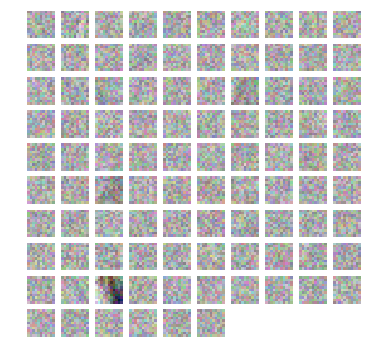

In [34]:
mlutils.display_imgs(model1.get_weights()[0])

## Part 2: Transfer learning

- load the model saved in the Transfer Learning notes
- show the shapes of all weights from the model built in Part 1 above and the model just loaded
- create a new model with the same architecture of Part 1
- transfer the weights from the loaded model. **Transfer only weights with the same shapes**!!!
- train!!!

you should get:

- must faster drop in loss in train data, even to large overfitting
- some improvement of accuracy in test data
- the nice alexnet layer 1 filters after you train your model mostly unmodified

In [35]:
from tensorflow.keras.models import load_model

model1 = get_model(2)
model2 = load_model("alexnet_finetuned_minicifar.model")
model2.summary()

using 2 classes
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                976  

In [55]:
w1 = model1.get_weights() # obtain weights of model 1
w2 = model2.get_weights() # obtain weights of model 2

In [56]:
print " -- model 1 weights --"
# print all weights shapes of model 1

for i in w1:
    print i.shape

 -- model 1 weights --
(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 64)
(64,)
(64, 64)
(64,)
(64, 2)
(2,)


In [57]:
print(w2[3].shape)
print " -- model 2 weights --"
# print all weights shapes of model 2

for i in w2:
    print i.shape

(60,)
 -- model 2 weights --
(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 16)
(16,)
(16, 3)
(3,)


### transfer weights!!

### you should transfer weights and biases of only the convolutional layers

`w1` must contain the transferred weights from `w2`

In [58]:
w1[0] = w2[0]
w1[1] = w2[1]
w1[2] = w2[2]
w1[3] = w2[3]

In [59]:
model1.set_weights(w1)

### train!!!

In [60]:
train(model1, 10,15, "model1_transfer")

Train on 800 samples, validate on 200 samples
Epoch 1/15
800/800 [==============================] - 7s 9ms/step - loss: 0.7339 - acc: 0.4950 - val_loss: 0.6946 - val_acc: 0.5650
Epoch 2/15
800/800 [==============================] - 4s 5ms/step - loss: 0.7079 - acc: 0.5400 - val_loss: 0.6938 - val_acc: 0.5650
Epoch 3/15
800/800 [==============================] - 4s 5ms/step - loss: 0.6866 - acc: 0.5625 - val_loss: 0.7104 - val_acc: 0.5450
Epoch 4/15
800/800 [==============================] - 4s 5ms/step - loss: 0.6593 - acc: 0.5813 - val_loss: 0.6893 - val_acc: 0.6050
Epoch 5/15
800/800 [==============================] - 4s 5ms/step - loss: 0.6364 - acc: 0.6575 - val_loss: 0.6905 - val_acc: 0.5800
Epoch 6/15
800/800 [==============================] - 4s 5ms/step - loss: 0.5597 - acc: 0.6875 - val_loss: 0.7365 - val_acc: 0.5650
Epoch 7/15
800/800 [==============================] - 4s 6ms/step - loss: 0.5074 - acc: 0.7550 - val_loss: 0.7861 - val_acc: 0.5900
Epoch 8/15
800/800 [==========

{'acc': 0.61, 'loss': 2.0585538959503173}

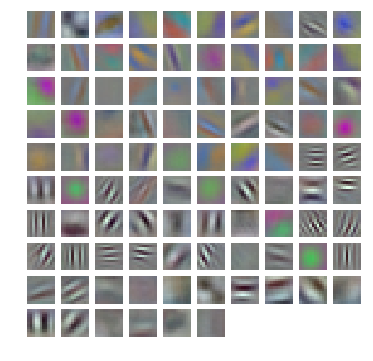

In [61]:
mlutils.display_imgs(model1.get_weights()[0])

Se observa una mejoría despues de la transferencia, donde las imágenes tienen 